# 1. Árbol de decisión para clasificación

**Objetivo:** entrenar y probar un modelo de árbol de decisión para clasificar tipo de uso de suelo a partir de imágenes satelitales.


Este dataset es usado para clasificar el uso de suelo en imágenes geoespaciales. 
https://www.kaggle.com/apollo2506/eurosat-dataset

**Información de las características**
Este dataset contiene imágenes que pertenecen all dataset de EuroSat. Hay 10 folders:
* 0 AnnualCrop
* 1 Forest
* 2 HerbaceousVegatation
* 3 Highway
* 4 Industrial
* 5 Pasture
* 6 PermanentCrop
* 7 Residential
* 8 River
* 9 SeaLake


**Número de instancias:** 27000

# 2. Autenticación a Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Importando librerías

In [2]:
import pandas as pd
import os
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics

# 4. Lectura del archivo

In [4]:
file_path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.3 Árbol de decisión'
images_path = r"/content/drive/My Drive/EuroSat/EuroSAT"
train_path = os.path.join(file_path,'EUROSAT_TRAIN_FEAT.csv')

In [5]:
train_df = pd.read_csv(train_path)
train_df.head()

,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,color_16,color_17,color_18,color_19,color_20,color_21,color_22,color_23,color_24,color_25,color_26,color_27,color_28,color_29,color_30,color_31,color_32,color_33,color_34,color_35,color_36,color_37,color_38,color_39,...,color_493,color_494,color_495,color_496,color_497,color_498,color_499,color_500,color_501,color_502,color_503,color_504,color_505,color_506,color_507,color_508,color_509,color_510,color_511,texture_0,texture_1,texture_2,texture_3,texture_4,texture_5,texture_6,texture_7,texture_8,texture_9,texture_10,texture_11,texture_12,Hu_0,Hu_1,Hu_2,Hu_3,Hu_4,Hu_5,Hu_6,label
0,0.0,0.0,0.000429,0.002575,0.001717,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.014593,0.012018,0.000429,0.000000,0.0,0.0,0.0,0.0,0.00000,0.022748,0.003863,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006973,23.040117,0.894417,110.144206,0.434422,203.396256,417.536707,5.810727,8.042798,0.001176,2.785816,-0.347483,0.981251,0.001636,1.474129e-10,9.088959e-13,1.238040e-13,3.785799e-26,-1.499442e-18,-1.707315e-26,AnnualCrop
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012056,8.327994,0.954820,92.368117,0.485495,128.941213,361.144472,5.391939,7.339855,0.002182,2.482645,-0.368246,0.979857,0.002638,1.679241e-09,5.095256e-11,4.445626e-11,1.772691e-21,-1.753889e-15,1.155135e-21,AnnualCrop
2,0.0,0.0,0.000000,0.007537,0.045220,0.022072,0.0,0.0,0.0,0.0,0.0,0.000000,0.058679,0.726218,0.577099,0.037145,0.0,0.0,0.0,0.0,0.00000,0.000000,0.136738,0.001077,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001521,104.983759,0.948826,1025.361539,0.308539,297.756791,3996.462396,7.336093,10.155426,0.000610,3.690089,-0.400293,0.996832,0.001118,1.542389e-09,7.932409e-13,5.521435e-12,1.154182e-23,1.639691e-16,-5.577083e-25,AnnualCrop
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000478,0.033963,0.027266,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00287,0.046879,0.647692,0.685004,0.0,0.0,0.0,0.0,0.0,0.0,0.094236,0.299928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003368,52.156309,0.957445,613.487385,0.354164,360.245280,2401.793232,6.712811,9.258063,0.000695,3.298105,-0.389142,0.993600,0.000908,2.647723e-09,1.190332e-12,1.161787e-12,-9.484001e-25,-1.877223e-18,9.834228e-25,AnnualCrop
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007743,9.679413,0.893749,45.822831,0.372521,153.012016,173.611911,5.275578,7.715428,0.001931,2.721910,-0.248826,0.930371,0.002141,2.549876e-09,1.263506e-12,3.164047e-12,-3.063017e-24,3.203858e-17,-5.535397e-24,AnnualCrop


In [6]:
train_df.shape

(27000, 533)

In [7]:
clases = train_df['label'].unique()
clases

array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], dtype=object)

# 5. Exploración de datos (EDA)

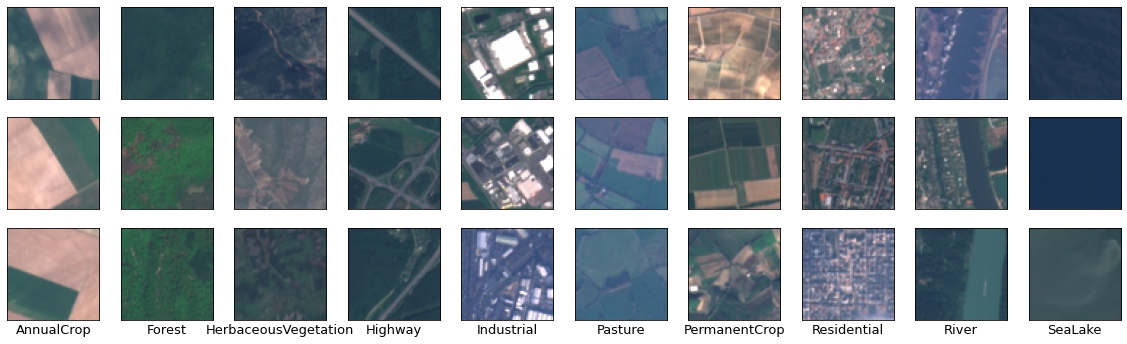

In [8]:
plt.figure(figsize=(20,20))
for i,folder in enumerate(clases):
    path_folder = os.path.join(images_path, folder)
    imgs_list =os.listdir(path_folder)
    random.shuffle(imgs_list)
    for j in range(3):
      img_path = os.path.join(path_folder,imgs_list[j])
      plt.subplot(10,10,j*10+i+1)
      img = plt.imread(img_path)
      plt.imshow(img)
      plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labelleft=False)
      if j==2:
        plt.xlabel(folder,
        horizontalalignment='center',
        verticalalignment='top', fontsize=13)
plt.show()

# 6. Limpieza de datos

#### a) Escalamiento

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df.loc[:, train_df.columns != 'label'] = scaler.fit_transform(train_df.loc[:, train_df.columns != 'label'])

#### b) Codificación de etiquetas

In [10]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)

### c) Análisis de componentes principales con varianza acumulada de al menos el 90%

In [11]:
pca = PCA(0.8)
pc = pca.fit_transform(train_df.iloc[:,:-1])
df_pca_train = pd.DataFrame(data = pc,
                           columns=range(pc.shape[1]))
df_pca_train = pd.concat([df_pca_train, train_df[['label']]], axis = 1)
df_pca_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,0.021655,0.273502,0.102364,0.061546,0.089783,0.007629,-0.261941,0.180699,0.442403,-0.172650,-0.224836,0.114530,-0.034808,0.067837,0.423538,0
1,0.622296,0.002815,-0.496311,-0.323319,-0.172456,-0.305126,-0.063467,0.060499,0.024346,-0.127143,-0.148231,0.024083,-0.133093,-0.027994,-0.078458,0
2,-0.423656,0.636943,0.034199,-0.211894,0.302205,-0.096718,0.135345,0.042499,-0.274190,0.003008,0.143233,0.423902,-0.199390,-0.093691,0.064369,0
3,-0.269740,0.527962,-0.008303,-0.093053,0.371391,-0.149039,-0.078730,0.035853,-0.132790,0.013478,-0.244529,0.084268,0.331820,-0.367814,0.058389,0
4,0.320276,0.251265,-0.457422,0.462987,-0.182128,-0.239392,0.289217,-0.188322,0.203603,-0.203343,-0.144228,0.100569,-0.045847,-0.040164,-0.145697,0


Imprimiendo el poder explicativo y el número de componentes principales

In [12]:
print('Número de componentes principales: %s'%len(pca.explained_variance_ratio_))
print('Varianza acumulada con %s componentes: %s'%(len(pca.explained_variance_ratio_),np.sum(pca.explained_variance_ratio_)))

Número de componentes principales: 15
Varianza acumulada con 15 componentes: 0.810186093450439


In [15]:
feat_names = ['PC_'+str(i+1) for i in range(len(pca.explained_variance_ratio_))]
df_pca_train.columns=feat_names+['label']
print(feat_names)

['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15']


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


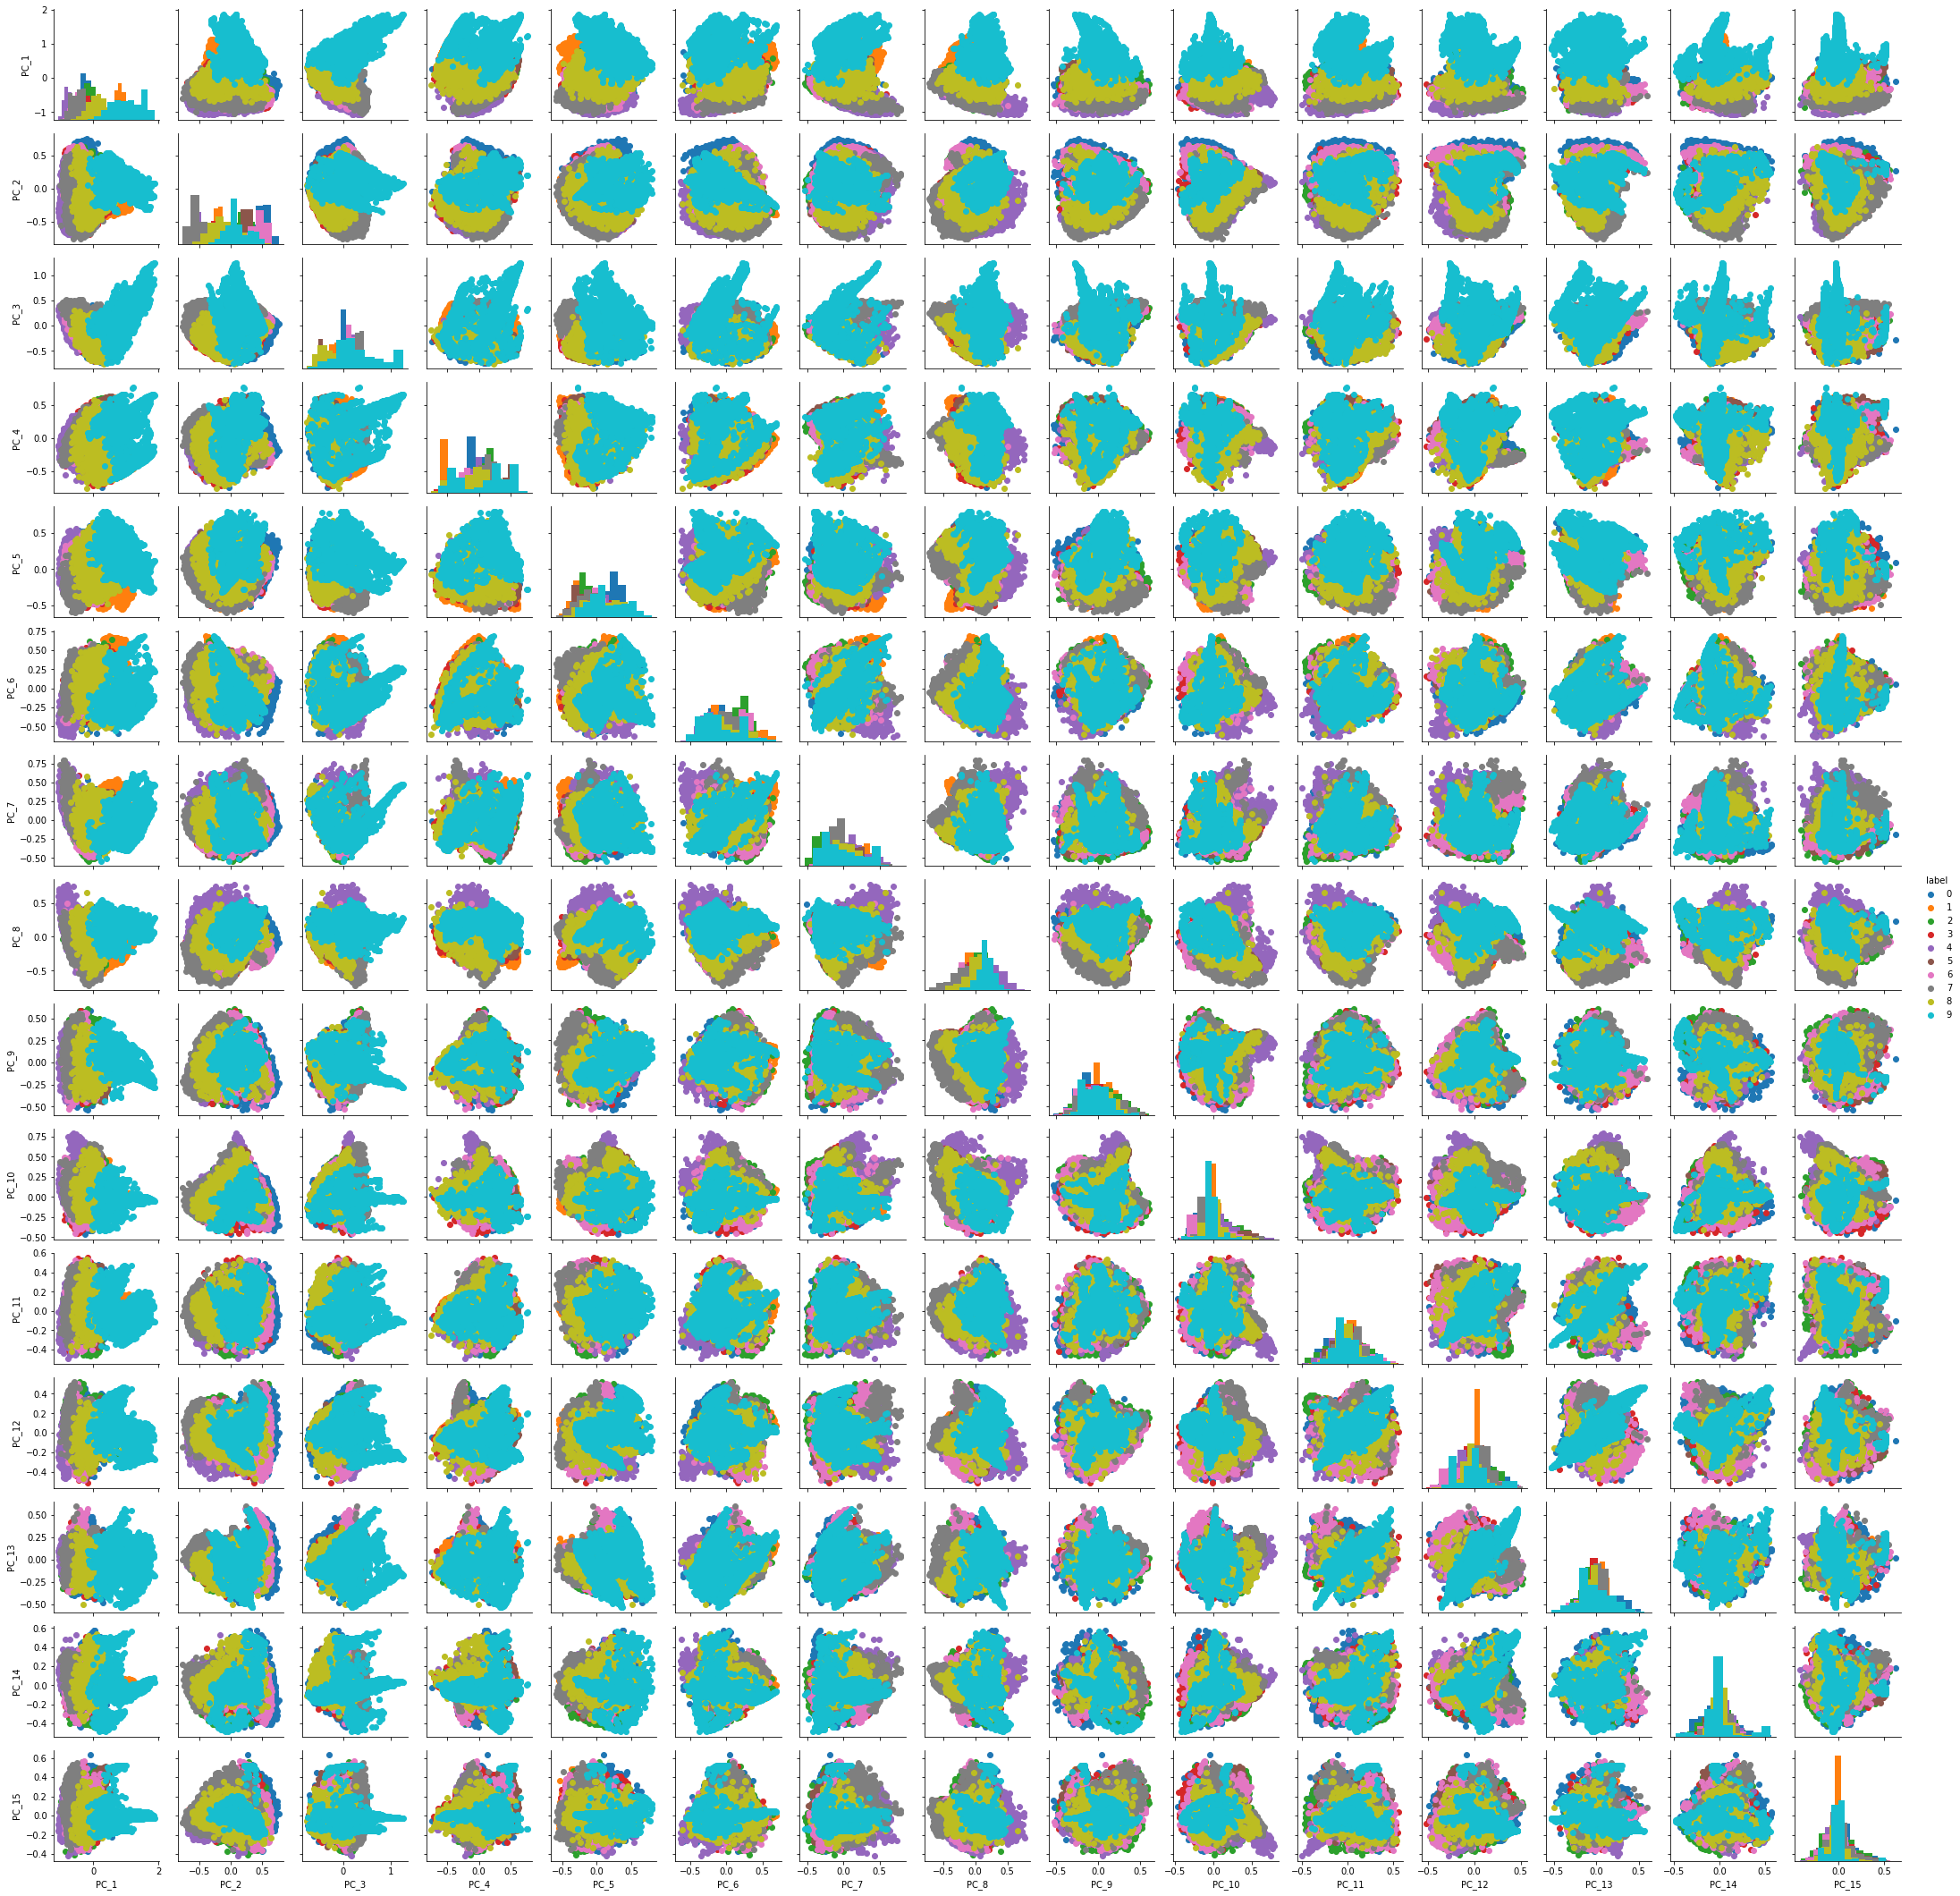

In [17]:
import seaborn as sns
g = sns.PairGrid(data=df_pca_train, vars=feat_names, hue='label', size=2)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

# 7. Modelo de árbol de decisión CART usando Holdout validation


In [18]:
seed = 6

In [19]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(pc, train_df['label'], test_size = 0.2, random_state = seed)

In [20]:
n_classes = len(clases)

# 8. Creando modelo 

c) Instanciando un árbol de decisión

In [21]:
dectree = DecisionTreeClassifier(random_state=seed)#, max_depth = 5)

d) Entrenamiento

In [22]:
dectree = dectree.fit(Xtrain,Ytrain)

**Score de entrenamiento**

In [23]:
dectree.score(Xtrain,Ytrain)

1.0

Plot del árbol

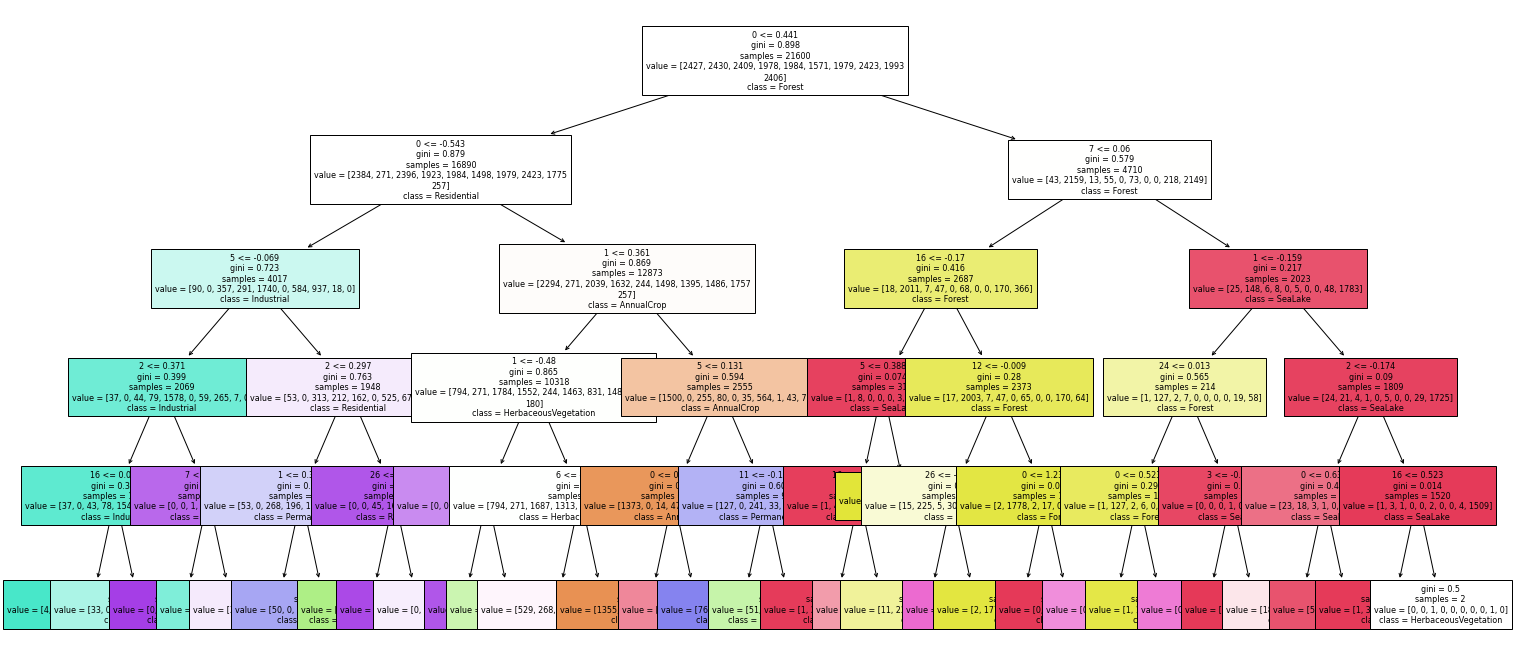

In [47]:
plt.figure(figsize = (25,12))
plot_tree(dectree, feature_names = feat_names, class_names = clases, filled = True, fontsize=8)
plt.savefig('dectree_eurosat.png',format='png',bbox_inches = "tight")

# 8. Prediciendo para los datos de prueba

In [24]:
y_pred = dectree.predict(Xtest)

a) Calculando el rendimiento general del modelo

In [25]:
score = metrics.accuracy_score(Ytest, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.7401851851851852


b) Predicciones vs etiquetas verdaderas

In [27]:
predictions = np.float32(y_pred)
true_labels = np.float32(Ytest)

c) Matriz de confusión para evaluar los errores

In [28]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera', fontsize=10)
    plt.xlabel('Clase Predicha', fontsize=10)
    plt.savefig(title+'.png')
    #plt.grid(b=None)
    plt.show()

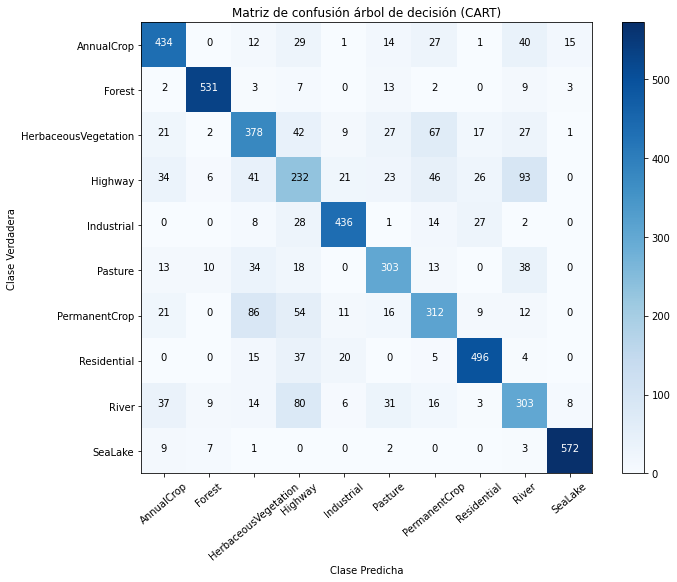

In [29]:
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_classes))
tit = 'Matriz de confusión árbol de decisión (CART)'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

e) Otras métricas para evaluar el rendimiento

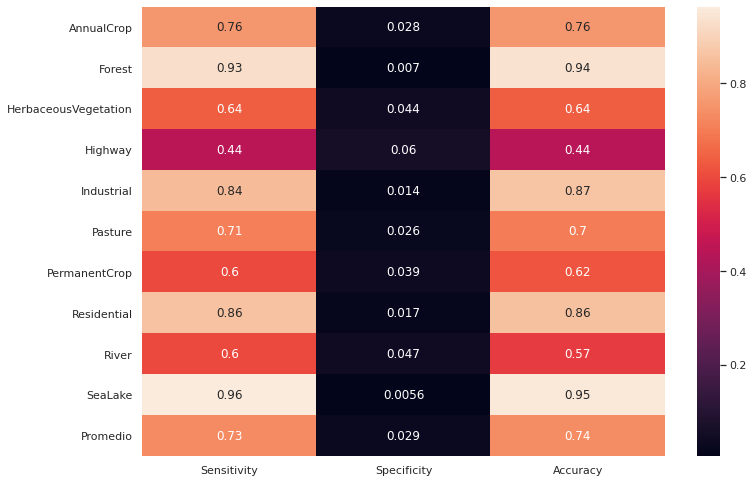

In [41]:
sensitivity = []
specificity = []
acc=[]
for i,name in enumerate(df_pca_train.label.unique()):
  TP = np.sum((true_labels==name) & (predictions==name))
  TN = np.sum((true_labels!=name) & (predictions!=name))
  FP = np.sum((true_labels!=name) & (predictions==name))
  FN = np.sum((true_labels==name) & (predictions!=name))
  sensitivity.append(TP/(TP+FN))
  specificity.append(FP/(TN+FP))
  acc.append(TP/(TP+FP))
sensitivity.append(sum([x*y for x,y in zip(sensitivity,[1/10]*10)]))
specificity.append(sum([x*y for x,y in zip(specificity,[1/10]*10)]))
acc.append(sum([x*y for x,y in zip(acc,[1/10]*10)]))
d = {'Sensitivity':sensitivity, 'Specificity':specificity, 'Accuracy':acc}
ind = list(clases)+['Promedio']
df = pd.DataFrame(d, index=ind)
index = df.index
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)